In [1]:
import tensorflow as tf

import keras.backend as K
import keras
K.set_image_data_format('channels_first')
from keras.backend.tensorflow_backend import set_session

from keras import callbacks
from keras.losses import categorical_crossentropy
from keras.optimizers import *

from keras.layers import *
from keras.models import Model, Sequential

import numpy as np
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  
config.gpu_options.per_process_gpu_memory_fraction = 0.95
set_session(tf.Session(config=config))

classes = 2
depth = 3
height = 720
width = 1280
batch_size = 1
save_after_epochs = 1

testDataPath = "./LaneDetection/seg_data/test/"
saveOutputPath = os.path.join(testDataPath, 'outputNew')
#trained model path
weightsPath = "./LaneDetection/seg_data/unet_depthwise/unet-norm-66-trainLoss-0.006949-trainAcc-1.00-trainFgDice-0.88-valLoss-0.150678-valAcc0.98-valFgDice0.35.h5"


C:\Users\ameya.deshpande\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ameya.deshpande\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ameya.deshpande\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\U

In [2]:
def sampleMeanStd(img):
    
    img  = img.astype("float32")
    
    b_ch=np.mean(img[:,:,0])
    g_ch=np.mean(img[:,:,1])
    r_ch=np.mean(img[:,:,2])

    #Individual channel-wise mean subtraction
    img -= np.array((b_ch,g_ch,r_ch))
    
    b_ch=np.std(img[:,:,0])
    g_ch=np.std(img[:,:,1])
    r_ch=np.std(img[:,:,2])
    
    img /= np.array((b_ch,g_ch,r_ch))
    
    return img

def relu6(x):
    return K.relu(x, max_value=6)

def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha = 1.0,
                          depth_multiplier=1, strides=(1, 1), block_id=1):

    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    x = ZeroPadding2D((1, 1), data_format='channels_first')(inputs)
    x = DepthwiseConv2D((3, 3), data_format='channels_first',
                        padding='valid',
                        depth_multiplier=depth_multiplier,
                        strides=strides,
                        use_bias=False)(x)
    x = BatchNormalization(
        axis=1)(x)
    x = Activation(relu6)(x)

    x = Conv2D(pointwise_conv_filters, (1, 1), data_format='channels_first',
               padding='same',
               use_bias=False,
               strides=(1, 1))(x)
    x = BatchNormalization(axis=1)(x)
    return Activation(relu6)(x)



def unet_depthwiseConv(pretrained_weights = None,input_size = (3, height, width)):
    
    
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = _depthwise_conv_block(pool1, pointwise_conv_filters = 64)
    conv2 = _depthwise_conv_block(conv2, pointwise_conv_filters = 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = _depthwise_conv_block(pool2, pointwise_conv_filters = 128)
    conv3 = _depthwise_conv_block(conv3, pointwise_conv_filters = 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = _depthwise_conv_block(pool3, pointwise_conv_filters = 256)
    conv4 = _depthwise_conv_block(conv4, pointwise_conv_filters = 256)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = _depthwise_conv_block(pool4, pointwise_conv_filters = 512)
    conv5 = _depthwise_conv_block(conv5, pointwise_conv_filters = 512)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 1)
    conv6 = _depthwise_conv_block(merge6, pointwise_conv_filters = 256)
    conv6 = _depthwise_conv_block(conv6, pointwise_conv_filters = 256)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 1)
    conv7 = _depthwise_conv_block(merge7, pointwise_conv_filters = 128)
    conv7 = _depthwise_conv_block(conv7, pointwise_conv_filters = 128)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 1)
    conv8 = _depthwise_conv_block(merge8, pointwise_conv_filters = 64)
    conv8 = _depthwise_conv_block(conv8, pointwise_conv_filters = 64)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 1)
    conv9 = _depthwise_conv_block(merge9, pointwise_conv_filters = 32)
    conv9 = _depthwise_conv_block(conv9, pointwise_conv_filters = 32)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    reshape = Reshape((2, width*height), input_shape = (2, height, width))(conv9)

    permut = Permute((2,1))(reshape)
    softmax = Activation('softmax')(permut)
    model = Model(inputs= [inputs], outputs= [softmax])
 
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [3]:
#This was used to perfomr bulk testing

import cv2

#make network and load weights
model = unet_depthwiseConv(weightsPath, input_size = (3, height, width))

#make output directory
if not os.path.exists(saveOutputPath):
    os.makedirs(saveOutputPath)

imgNames = [f for f in os.listdir( testDataPath ) if f.endswith('.jpg')]
for imgName in imgNames:
    
    testImg = cv2.imread( os.path.join(testDataPath, imgName) )
    testImg = sampleMeanStd(testImg)

    data = []
    data.append(np.rollaxis((testImg), 2))
    data = np.array(data)
    prob = model.predict(data)
    
    prediction = prob[0]
    prediction = np.uint8(np.argmax(prediction, axis=1))
    prediction = np.uint8( (255*prediction.astype('float32'))/(classes-1) )
    prediction = np.reshape(prediction,(height, width))

    cv2.imwrite( os.path.join(saveOutputPath, imgName.split('.jpg')[0] + '.png'), prediction )
    print('Done :', imgName)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Done : 01759047-d88724fe.jpg
Done : 0350503e-d3efc96a.jpg
Done : 0553008d-613fe2ed.jpg
Done : 065992a2-8765cbc1.jpg
Done : 081319cb-f5f092a4.jpg
Done : 0968013e-6df14f09.jpg
Done : 123239f3-f0d9bb95.jpg
Done : 1847344d-08a6e901.jpg
Done : 223046e4-f35461a6.jpg
Done : 239471e5-2431dd3d.jpg
Done : 2532100b-e5e84370.jpg
Done : 298726c9-a4add63c.jpg
Done : 320473dd-483aeeb8.jpg
Done : 3283384c-575a877f.jpg
Done : 3590035e-a555f10c.jpg
Done : 367049d3-e2924bcb.jpg
Done : 4282002e-40ff695f.jpg
Done : 450377af-97132b79.jpg
Done : 4605075f-e751aec4.jpg
Done : 507901e3-7d2df5c6.jpg
Done : 508522be-b1c5f800.jpg
Done : 54549e0f-08d7f11e.jpg
Done : 5516345c-c88ad688.jpg
Done : 5617290e-5b9f4be3.jpg
Done : 59156a5c-17515447.jpg
Done : 60922345-d32b3390.jpg
Done : 61189feb-b3b6f55a.jpg
Done : 65432146-90f5dc13.jpg
D

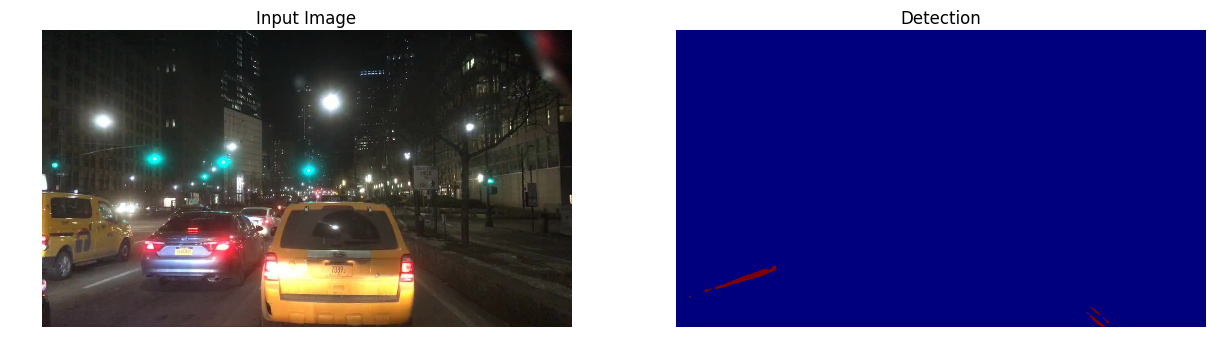

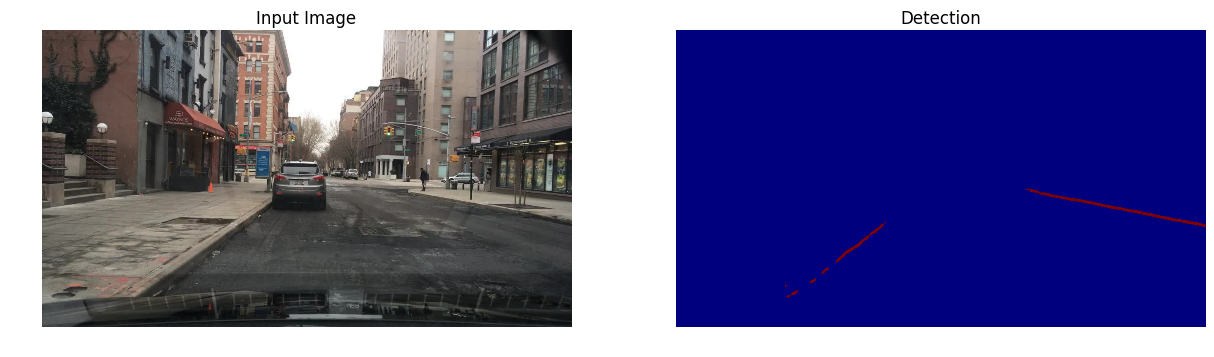

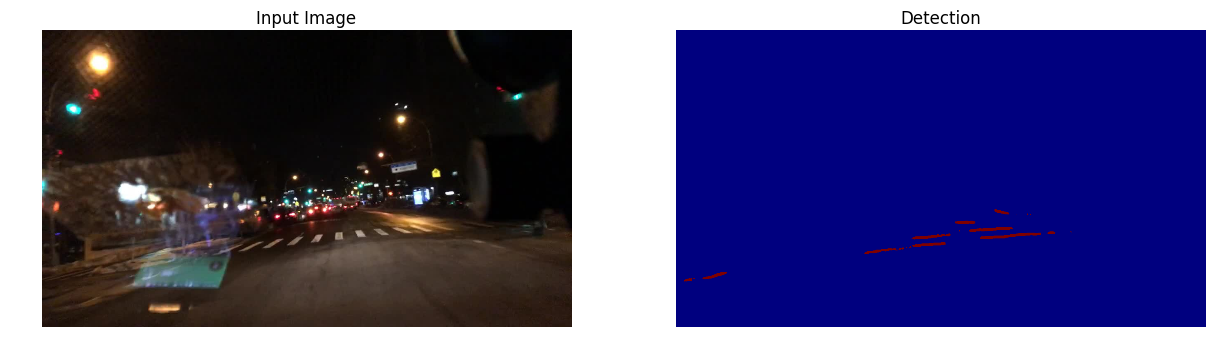

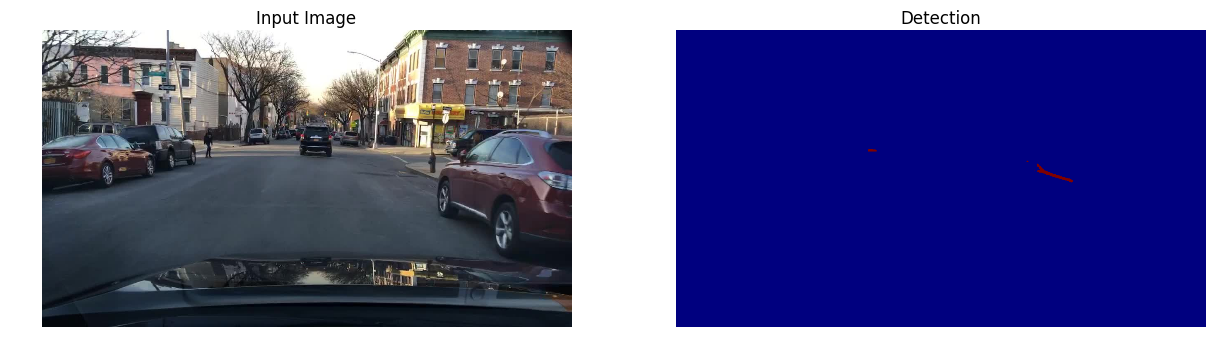

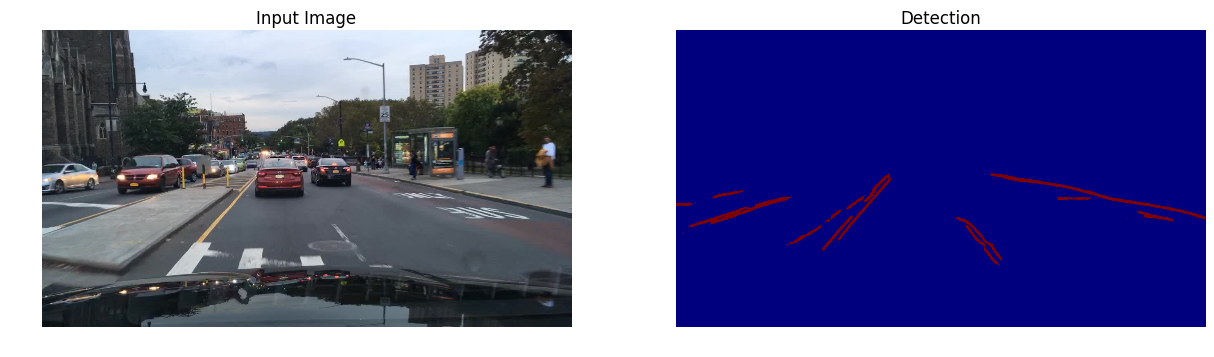

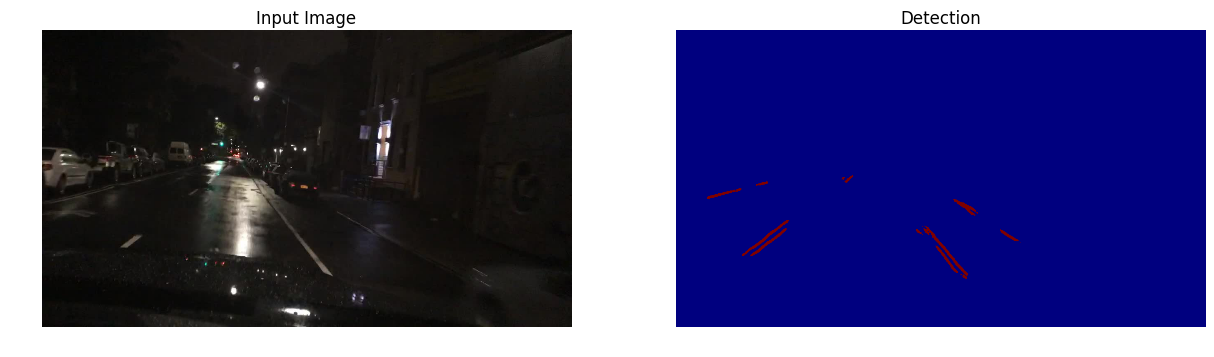

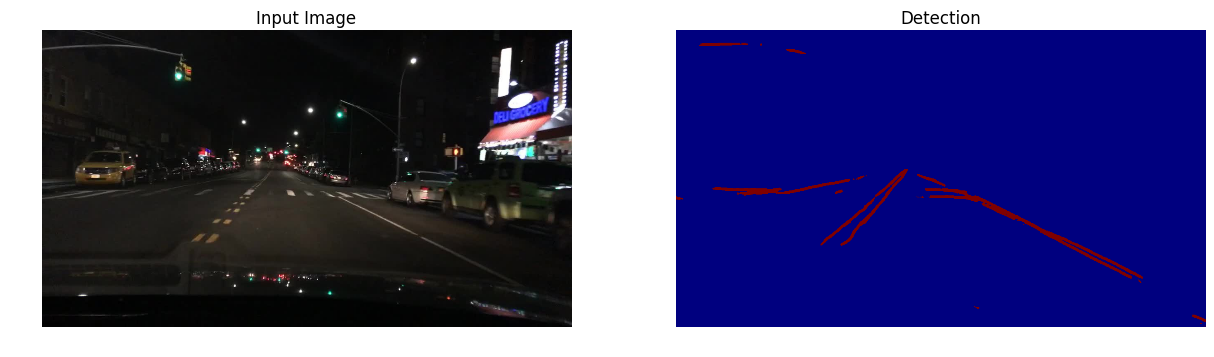

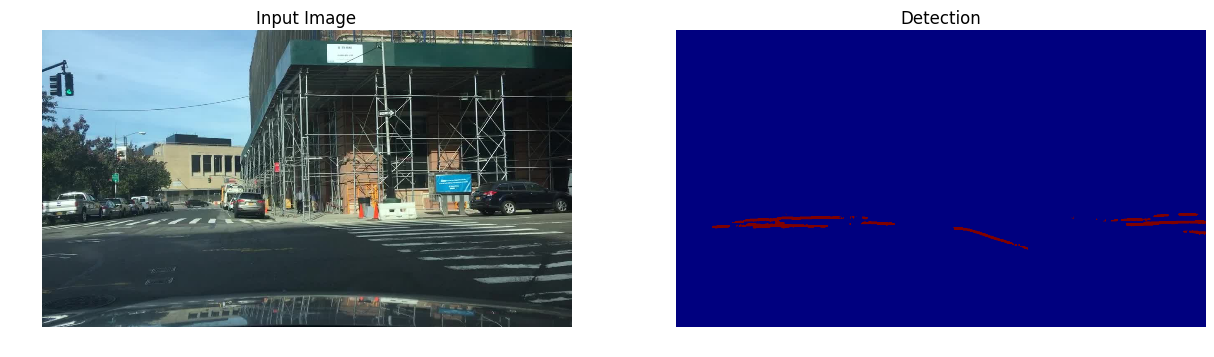

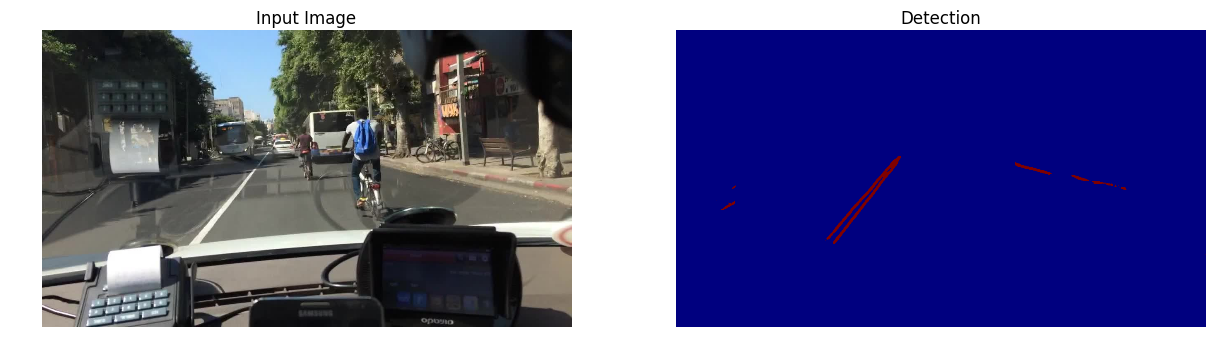

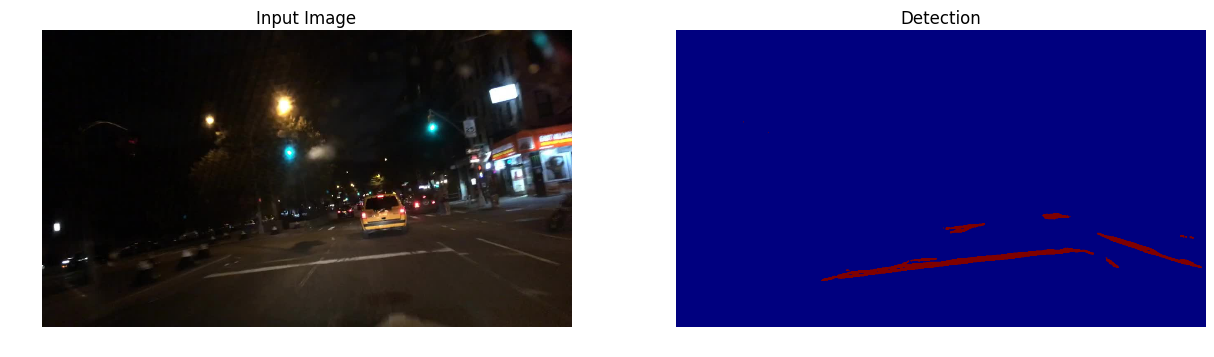

In [4]:
# Randomly show 10 outputs from test set
import random
import matplotlib.pyplot as plt

if not os.path.exists(saveOutputPath):
    os.makedirs(saveOutputPath)

imgNames = [f for f in os.listdir( testDataPath ) if f.endswith('.jpg')]
#randomly sample 10 images
imgNamesRandom = random.sample(imgNames, 10)

for imgName in imgNamesRandom:

    testImg = cv2.imread( os.path.join(testDataPath, imgName) )
    testImgRgb = cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB)
    testImg = sampleMeanStd(testImg)

    data = []
    data.append(np.rollaxis((testImg), 2))
    data = np.array(data)
    prob = model.predict(data)
    
    prediction = prob[0]
    prediction = np.uint8(np.argmax(prediction, axis=1))
    prediction = np.uint8( (255*prediction.astype('float32'))/(classes-1) )
    prediction = np.reshape(prediction,(height, width))

    plt.figure(figsize=(15,15))
    disp = [testImgRgb,  prediction]
    title = ['Input Image', 'Detection']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(disp[i])
        plt.axis('off')
        
    plt.show()